#### Importing Libraries and Datasets

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_fake = pd.read_csv(r'C:\Users\tejas\Downloads\Fake.csv')
data_true = pd.read_csv(r'C:\Users\tejas\Downloads\True.csv')

In [3]:
# Add flag to track fake and real

data_fake['target'] = 'fake'
data_true['target'] = 'true'

#### Data Preprocessing

In [4]:
# Concatenate dataframes
data = pd.concat([data_fake, data_true]).reset_index(drop = True)
data.shape

(44898, 5)

In [5]:
data.target.unique()

array(['fake', 'true'], dtype=object)

In [6]:
data.target.replace({'fake':0,'true':1}, inplace=True)

In [7]:
data.target.unique()

array([0, 1], dtype=int64)

In [8]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
# Check the data
data.head()

,title,text,subject,date,target
0,CUBA STILL A COMMIE HELLHOLE AFTER OBAMA’S “NO...,Don t you know Obama would love to just throw ...,politics,"Apr 13, 2015",0
1,"Civil liberties groups sue U.S., seek details ...",BOSTON (Reuters) - Civil liberties groups on W...,politicsNews,"April 12, 2017",1
2,AWESOME! SEAN SPICER Gives Trump’s Salary Away...,Zinke and Brandyburg accompanied Spicer to the...,politics,"Apr 3, 2017",0
3,BREAKING: WHY IS OBAMA Sending Huge Number Of ...,The largest armed U.S. military brigade to be ...,politics,"Jan 9, 2017",0
4,Flynn prepared to testify Trump directed him t...,"WASHINGTON (Reuters) - Michael Flynn, former n...",politicsNews,"December 1, 2017",1


As the title and date column will not going to be helpful in identification of the news. So, we can drop these column.

In [10]:
data = data.drop(["title","date"], axis = 1)

Now, we have to check if there is any null value

In [11]:
data.isnull().sum()

text       0
subject    0
target     0
dtype: int64

Now we have to shuffle the dataset to prevent the model to get bias. After that we will reset the index and then drop it. Because index column is not useful to us.

In [12]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


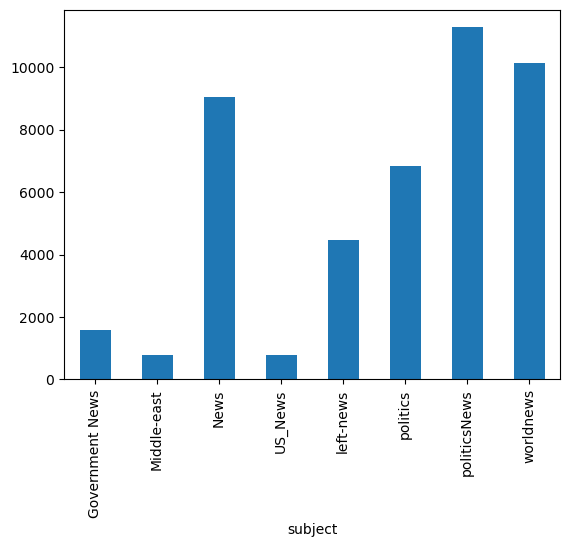

In [13]:
# How many articles per subject?

print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [14]:
def wordpot(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '',text)
    text = re.sub('\\w', '',text)
    text = re.sub('https?://\S+|www\.\S+', '',text)
    text = re.sub('<.*?>+', '',text)
    text = re.sub('[%s]'% re.escape(string.punctuation), '',text)
    text = re.sub('\n', '',text)
    text = re.sub('\w*\d\w*', '',text)
    return text

Now Let’s explore the unique values in the each category using below code.

<AxesSubplot:xlabel='target', ylabel='count'>

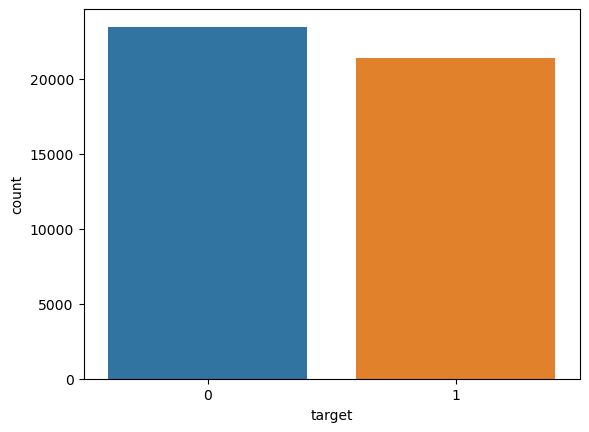

In [15]:
sns.countplot(data=data,
              x='target',
              order=data['target'].value_counts().index)

Preprocessing and analysis of News column

Firstly we will remove all the stopwords, punctuations and any irrelevant spaces from the text. For that NLTK Library is required and some of it’s module need to be downloaded. So, for that run the below code.

In [16]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [17]:
def preprocess_text(text_data):
    preprocessed_text = []
      
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed_text

To implement the function in all the news in the text column, run the below command. This command  will take some time (as the dataset taken is very large).

In [36]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████████████████████████████████████████████████████████████████████| 44898/44898 [2:01:08<00:00,  6.18it/s]


#### visualize the WordCloud for fake and real news separately.

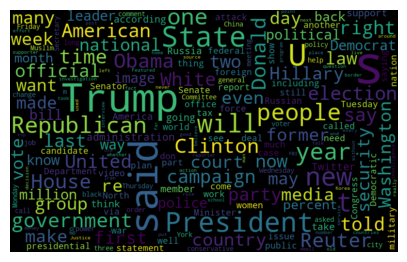

In [18]:
# Most frequent word in real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

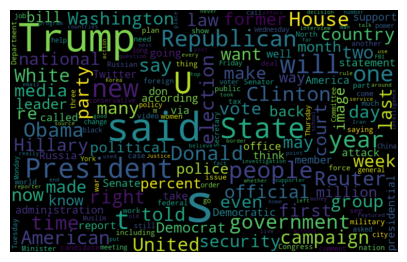

In [19]:
# Most frequent words in fake news

from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now, Let’s plot the bargraph of the top 20 most frequent words.

<AxesSubplot:title={'center':'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

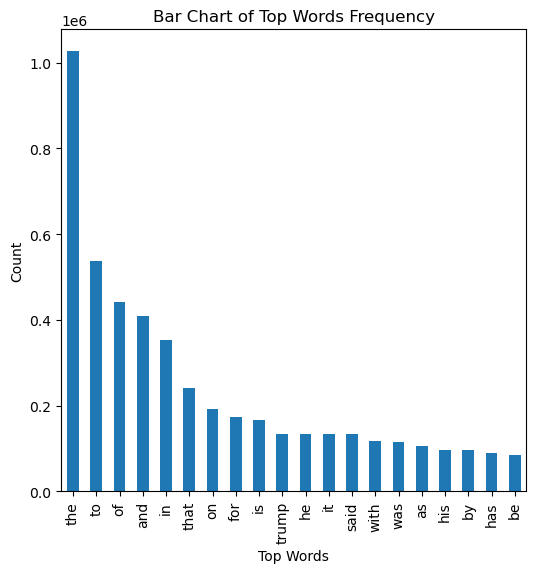

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
  
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(6, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency")

Converting text into Vectors

Before converting the data into vectors, split it into train and test.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(data['text'],
data['target'],test_size=0.25)

Now we can convert the training data into vectors using TfidfVectorizer.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

#### Model training, Evaluation, and Prediction

Now, the dataset is ready to train the model.
For training we will use Logistic Regression & Naive Bayes and evaluate the prediction accuracy using accuracy_score, confusion matrix, classification report

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)
train_pred_lr= lr.predict(x_train)
pred_lr= lr.predict(x_test)

# testing the model
print('Train_acc =',accuracy_score(y_train, train_pred_lr))
print('Test_acc = ',accuracy_score(y_test, pred_lr),'\n')
print('classification_report', '\n\n',classification_report(y_test,pred_lr),'\n')
print('Confusion_matrix_LR', '\n\n',confusion_matrix(y_test, pred_lr))

Train_acc = 0.9919817064116652
Test_acc =  0.9855679287305122 

classification_report 

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      5932
           1       0.98      0.99      0.98      5293

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225
 

Confusion_matrix_LR 

 [[5832  100]
 [  62 5231]]


In [24]:
from sklearn.naive_bayes import MultinomialNB

nb= MultinomialNB()
nb.fit(x_train, y_train)
train_pred_nb= nb.predict(x_train)
pred_nb= nb.predict(x_test)

# testing the model
print('Train_acc =', accuracy_score(y_train, train_pred_nb))
print('Test_acc = ', accuracy_score(y_test, pred_nb),'\n')
print('classification_report', '\n\n',classification_report(y_test, pred_nb),'\n')
print('Confusion_matrix_NB', '\n\n',confusion_matrix(y_test, pred_nb))

Train_acc = 0.9461586434235144
Test_acc =  0.9378173719376391 

classification_report 

               precision    recall  f1-score   support

           0       0.93      0.95      0.94      5932
           1       0.94      0.92      0.93      5293

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225
 

Confusion_matrix_NB 

 [[5638  294]
 [ 404 4889]]


In [25]:
def output_label(n):
    if n == 0:
        return 'Fake News'
    elif n == 1:
        return 'True News'

In [26]:
def manual_testing(news):
    testing_news = {'text':[news]}
    new_def_train = pd.DataFrame(testing_news)
    new_def_train['text'] = new_def_train['text'].apply(wordpot)
    new_x_train = new_def_train['text']
    new_xv_train = vectorization.transform(new_x_train)
    pred_lR = lr.predict(new_xv_train)
    pred_nb = nb.predict(new_xv_train)
    
    return print('\n\nlr Prediction:{} \nnb Prediction: {} '.format (output_label(pred_lR[0]),
                                                                    output_label(pred_nb[0])))

In [27]:
import string

In [28]:
new = str(input())
manual_testing(new)

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

### Conclusion

Logistic regression and Naive Bayes both are performing well.